In [153]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .
! pip install gym

fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
import neurogym as ngym
import torch
import numpy as np
from collections import namedtuple
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from neurogym.wrappers import pass_reward
import gym

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CartPole Task

In [43]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import namedtuple, deque
from neurogym.wrappers import pass_reward

env = gym.make('CartPole-v1')
#env = ngym.make('PerceptualDecisionMaking-v0')
#env = pass_reward.PassReward(env)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [44]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [46]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]


steps_done = 0


def select_action(state, policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():

            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            return policy_net(state).argmax(dim=1).item()
    else:
        return random.randrange(n_actions)

# Replay memory for experience replay
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = []
        self.capacity = capacity
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Initialize replay memory
memory = ReplayMemory(10000)


In [47]:
# Initialize policy and target networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

In [48]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute the loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Episode 0, Total Reward: 1.3999999999999997
Episode 1, Total Reward: 2.8
Episode 2, Total Reward: 5.800000000000001
Episode 3, Total Reward: 2.8
Episode 4, Total Reward: 2.0
Episode 5, Total Reward: 5.0
Episode 6, Total Reward: 1.9
Episode 7, Total Reward: 4.0
Episode 8, Total Reward: 3.9
Episode 9, Total Reward: 3.9
Episode 10, Total Reward: 5.9
Episode 11, Total Reward: 2.0
Episode 12, Total Reward: 4.0
Episode 13, Total Reward: 4.0
Episode 14, Total Reward: 3.8
Episode 15, Total Reward: 2.9
Episode 16, Total Reward: 3.9
Episode 17, Total Reward: 5.0
Episode 18, Total Reward: 3.0
Episode 19, Total Reward: 7.0
Episode 20, Total Reward: 3.0
Episode 21, Total Reward: 5.0
Episode 22, Total Reward: 4.9
Episode 23, Total Reward: 4.0
Episode 24, Total Reward: 5.0
Episode 25, Total Reward: 4.0
Episode 26, Total Reward: 6.0
Episode 27, Total Reward: 2.8
Episode 28, Total Reward: 2.8
Episode 29, Total Reward: 4.0
Episode 30, Total Reward: 1.9
Episode 31, Total Reward: 3.8
Episode 32, Total Rew

Episode 4999, Total Reward: 5.0


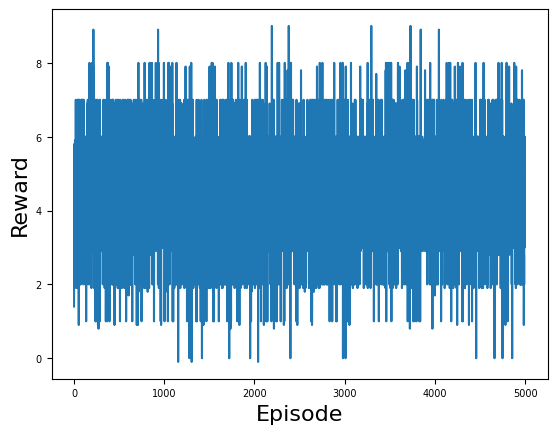

In [50]:
num_episodes = 500
steps_done = 0
scores = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    for t in range(200):

        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(state_tensor, policy_net)
        steps_done += 1


        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state_tensor = None if done else torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)


        memory.push(
            state_tensor,
            torch.tensor([[action]], dtype=torch.long, device=device),
            next_state_tensor,
            torch.tensor([reward], dtype=torch.float32, device=device)
        )


        state = next_state
        optimize_model()

        if done:
            break

    scores.append(total_reward)

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode}, Total Reward: {total_reward}")

env.close()

# Plot scores
plt.plot(scores)
plt.xlabel('Episode', fontsize = 16)
plt.ylabel('Reward', fontsize = 16)

plt.show()


Attempting to do it for GoNoGo Task - Just to let you know this doesnt work

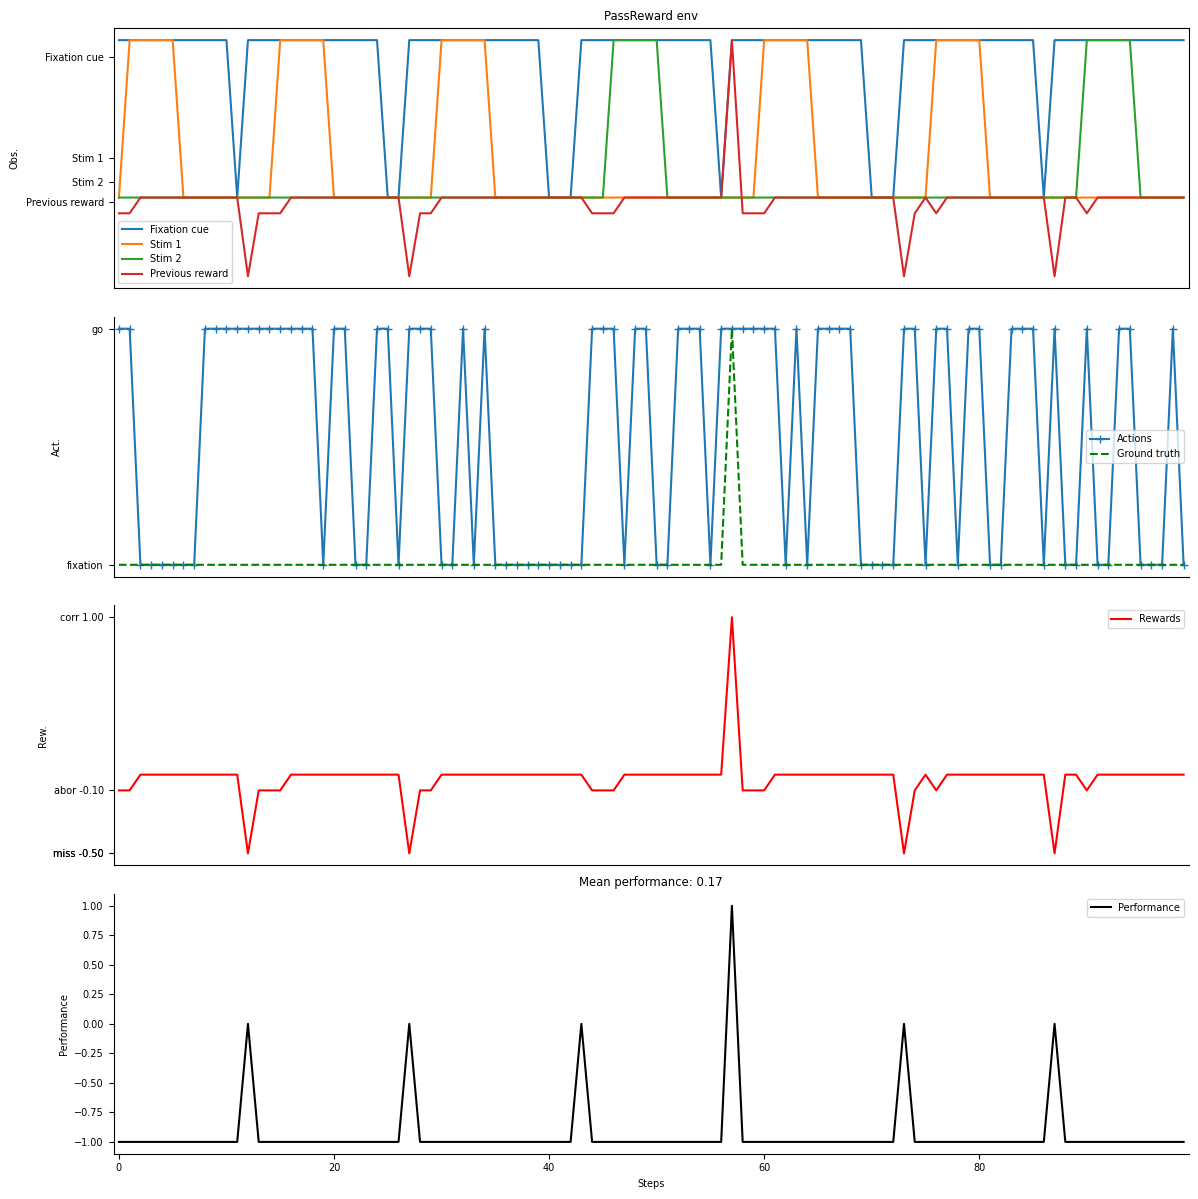

In [145]:

plt.rcParams['font.family'] = 'DejaVu Sans'
# Create the Go/No-Go environment
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 500),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing}
env = ngym.make('GoNogo-v0',**kwargs)

env = pass_reward.PassReward(env)
#env = ngym.make('PerceptualDecisionMaking-v0')
data = ngym.utils.plot_env(env, fig_kwargs={'figsize': (12, 12)}, num_steps=100, ob_traces=['Fixation cue', 'Stim 1', 'Stim 2', 'Previous reward'])


In [146]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [147]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Initialize action and observation space
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

# Epsilon decay schedule
steps_done = 0

# Helper function for selecting actions
def select_action(state, policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

# Replay memory for experience replay
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = []
        self.capacity = capacity
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Initialize replay memory
memory = ReplayMemory(10000)

In [148]:
# Initialize policy and target networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

In [149]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute the loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Episode 1/5000, Total Reward: -0.5
Episode 2/5000, Total Reward: 2.3
Episode 3/5000, Total Reward: -0.5
Episode 4/5000, Total Reward: 2.4
Episode 5/5000, Total Reward: 0.6999999999999997
Episode 6/5000, Total Reward: 2.5
Episode 7/5000, Total Reward: 4.0
Episode 8/5000, Total Reward: 0.9
Episode 9/5000, Total Reward: 2.5
Episode 10/5000, Total Reward: -0.6
Episode 11/5000, Total Reward: 1.0
Episode 12/5000, Total Reward: 2.5
Episode 13/5000, Total Reward: -0.7000000000000002
Episode 14/5000, Total Reward: 2.3
Episode 15/5000, Total Reward: 3.9
Episode 16/5000, Total Reward: -2.1
Episode 17/5000, Total Reward: 1.0
Episode 18/5000, Total Reward: 1.0
Episode 19/5000, Total Reward: 1.0
Episode 20/5000, Total Reward: 0.8999999999999999
Episode 21/5000, Total Reward: 3.6999999999999997
Episode 22/5000, Total Reward: -0.6000000000000001
Episode 23/5000, Total Reward: 2.5
Episode 24/5000, Total Reward: 3.9000000000000004
Episode 25/5000, Total Reward: -0.6
Episode 26/5000, Total Reward: 1.0
Ep

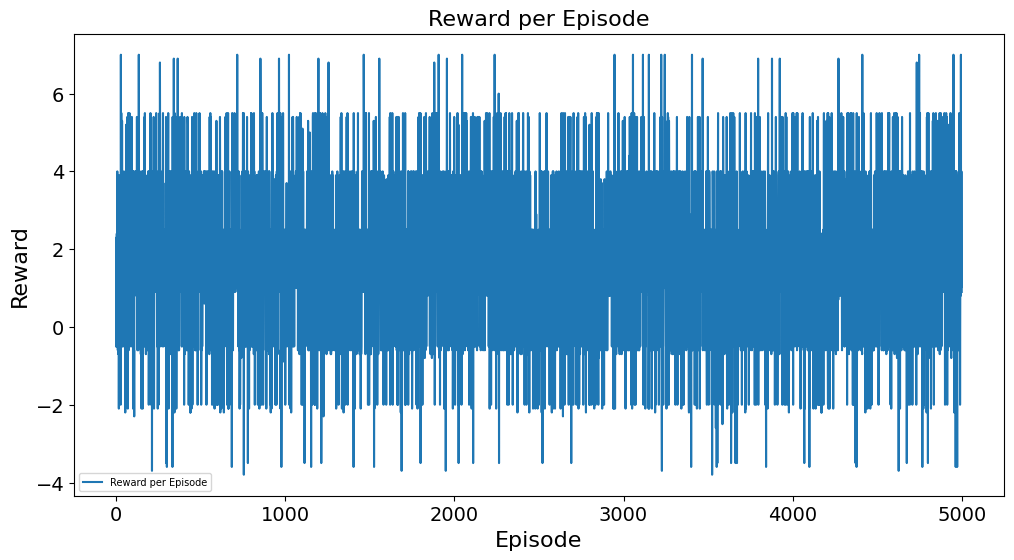

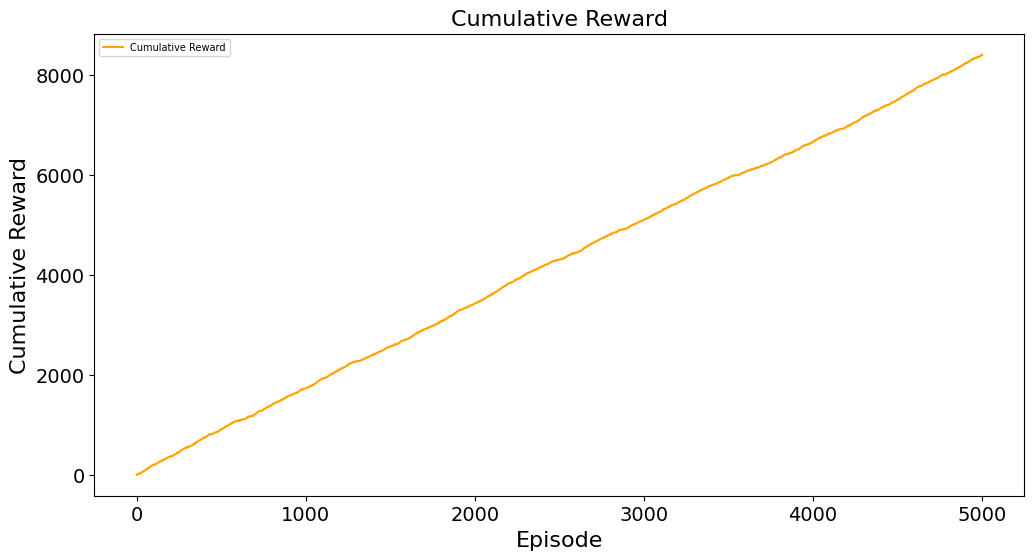

In [151]:
rewards_per_episode = []
cumulative_rewards = []
total_accumulated_reward = 0

num_episodes = 5000

for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    total_reward = 0

    for t in range(100):  # Limit the number of steps per episode
        action = select_action(state, policy_net)
        observation, reward, done, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        reward = reward
        # Observe new state
        next_state = torch.tensor([observation], device=device, dtype=torch.float32) if not done else None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimize the model
        optimize_model()

        if done:
            break

    # Update the target network
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = TAU * policy_net_state_dict[key] + (1 - TAU) * target_net_state_dict[key]
    target_net.load_state_dict(target_net_state_dict)

    # Track rewards
    total_accumulated_reward += total_reward
    rewards_per_episode.append(total_reward)
    cumulative_rewards.append(total_accumulated_reward)

    print(f"Episode {i_episode + 1}/{num_episodes}, Total Reward: {total_reward}")


plt.figure(figsize=(12, 6))
plt.plot(range(1, num_episodes + 1), rewards_per_episode, label="Reward per Episode")
plt.xlabel("Episode", fontsize = 16)
plt.ylabel("Reward", fontsize = 16)
plt.title("Reward per Episode", fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.show()

# Plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_episodes + 1), cumulative_rewards, label="Cumulative Reward", color="orange")
plt.xlabel("Episode", fontsize = 16)
plt.ylabel("Cumulative Reward", fontsize = 16)
plt.title("Cumulative Reward", fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.show()